# Análise por Eventos lendo direto do HDFS
Este notebook conecta-se ao cluster Spark (standalone) e lê as janelas de eventos direto do HDFS, gerando gráficos por evento com linhas por **categoria**.

In [1]:
import os, json, re
from datetime import datetime
import matplotlib.pyplot as plt

# Garante PySpark via findspark se não estiver instalado
try:
    from pyspark.sql import SparkSession, functions as F
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'findspark'])
    import findspark, os
    findspark.init(os.environ.get('SPARK_HOME', '/spark'))
    from pyspark.sql import SparkSession, functions as F

plt.style.use('ggplot')
events_cfg = '/opt/config/events.json'  # montado no container

spark = (SparkSession.builder
         .appName('EventAnalysisNotebook')
         .master('spark://spark-master:7077')
         .config('spark.hadoop.fs.defaultFS','hdfs://namenode:8020')
         .getOrCreate())

def slugify(name: str) -> str:
    return re.sub(r'[^a-z0-9_\-]', '-', name.lower().replace(' ', '-'))

def pick_price_column_spark(columns):
    if 'AdjClose' in columns: return 'AdjClose'
    if 'Adj Close' in columns: return 'Adj Close'
    return 'Close'

def normalize_by_anchor_spark(df, anchor_date: str):
    df = df.withColumn('date', F.to_date('date'))
    price_col = pick_price_column_spark(df.columns)
    # baseline: valor por categoria no dia da âncora; fallback: primeiro dia disponível
    anchor_df = (df.filter(F.col('date') == F.lit(anchor_date))
                   .groupBy('category').agg(F.first(price_col).alias('baseline')))
    if anchor_df.rdd.isEmpty():
        first_day = df.groupBy('category').agg(F.min('date').alias('min_date'))
        anchor_df = (df.join(first_day, ['category'])
                       .filter(F.col('date') == F.col('min_date'))
                       .groupBy('category').agg(F.first(price_col).alias('baseline')))
    out = (df.join(anchor_df, ['category'], 'left')
             .withColumn('index', (F.col(price_col) / F.col('baseline')) * F.lit(100.0)))
    return out

def aggregate_for_plot(df):
    return (df.groupBy('category','date')
              .agg(F.mean('index').alias('index'))
              .orderBy('date'))

events = json.load(open(events_cfg, 'r'))
events


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/04 23:04:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[{'name': 'Eleições EUA 2016', 'anchor_date': '2016-11-08', 'window_days': 60},
 {'name': 'Eleições EUA 2020', 'anchor_date': '2020-11-03', 'window_days': 60},
 {'name': 'Eleições EUA 2024', 'anchor_date': '2024-11-05', 'window_days': 60},
 {'name': 'Invasão Rússia-Ucrânia',
  'anchor_date': '2022-02-24',
  'window_days': 60},
 {'name': 'Pandemia COVID (WHO)',
  'anchor_date': '2020-03-11',
  'window_days': 60},
 {'name': 'Guerra comercial EUA-China (Tarifas iniciais)',
  'anchor_date': '2018-07-06',
  'window_days': 60},
 {'name': 'Guerra comercial EUA-China (Tarifas adicionais)',
  'anchor_date': '2018-09-24',
  'window_days': 60}]

Evento: Eleições EUA 2016 (âncora: 2016-11-08)


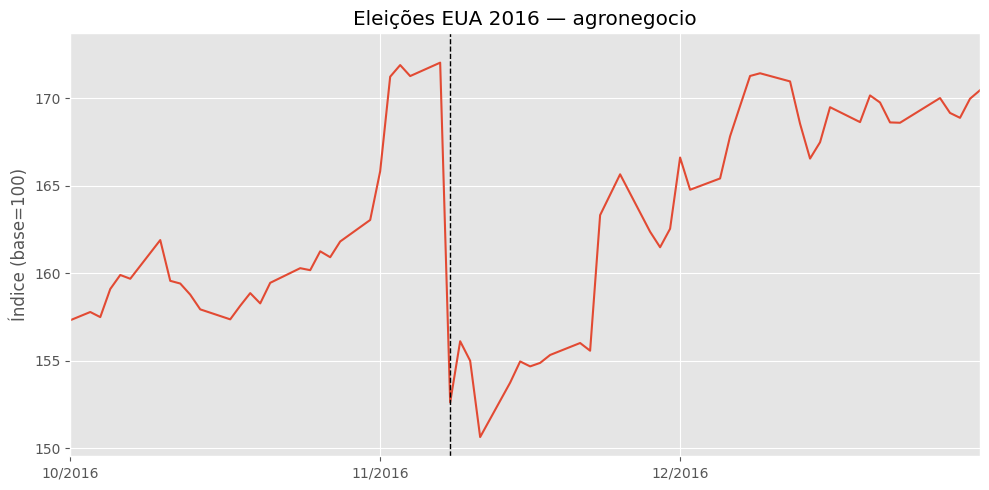

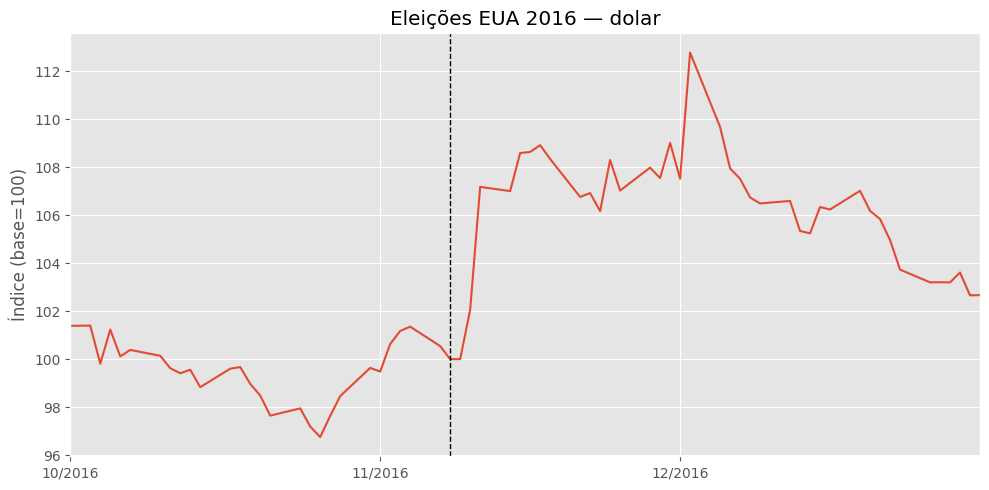

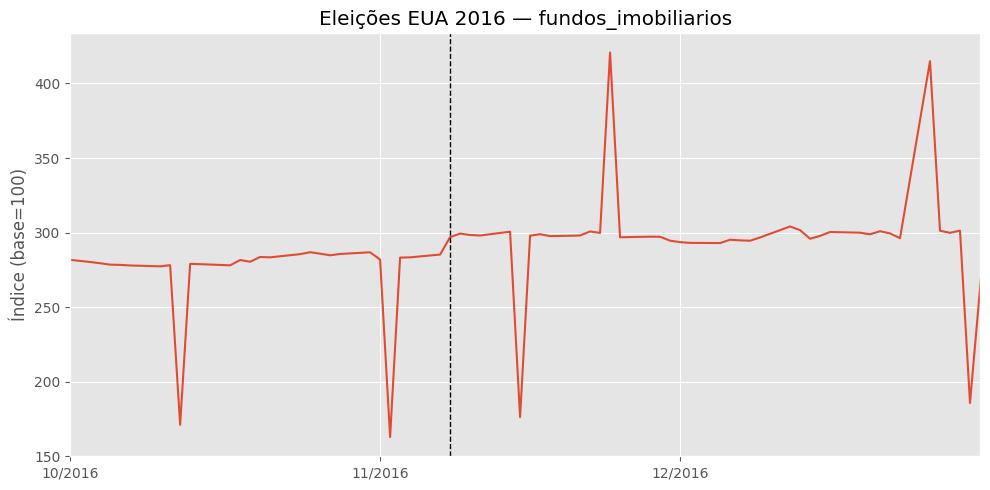

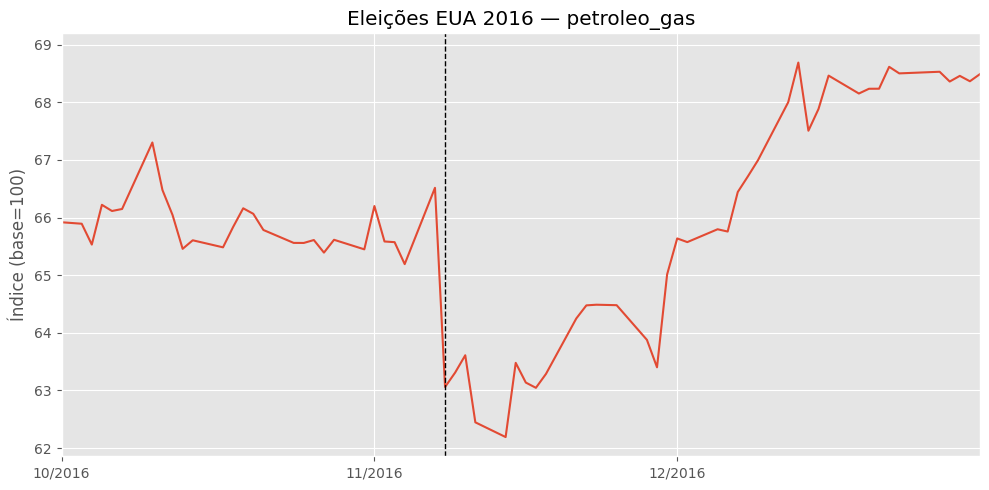

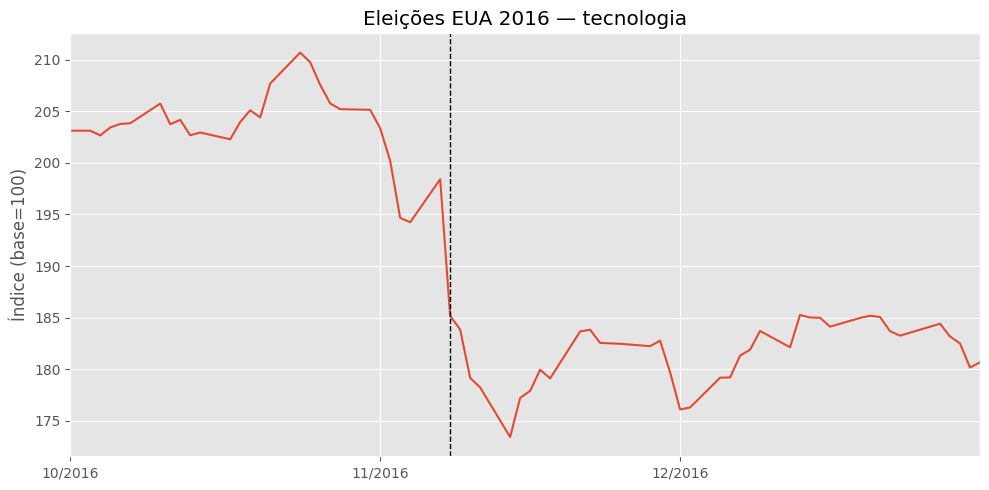

Evento: Eleições EUA 2020 (âncora: 2020-11-03)


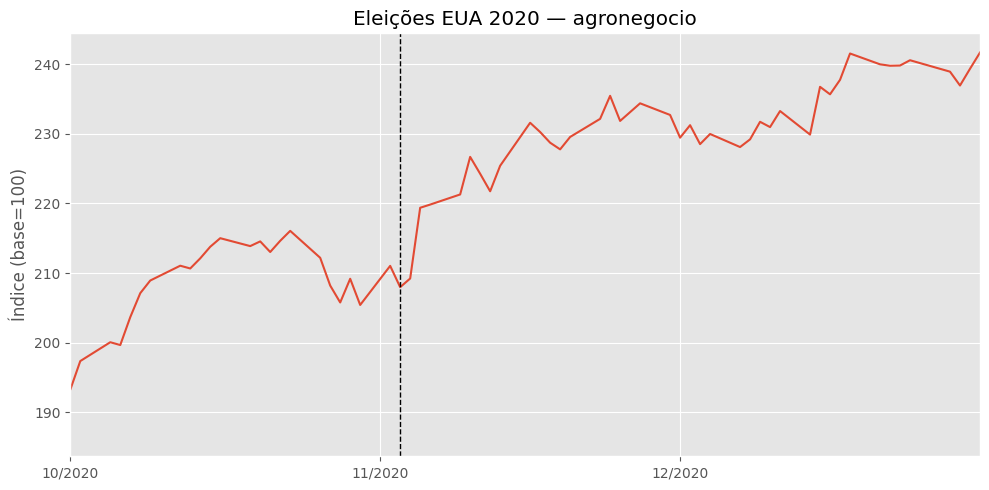

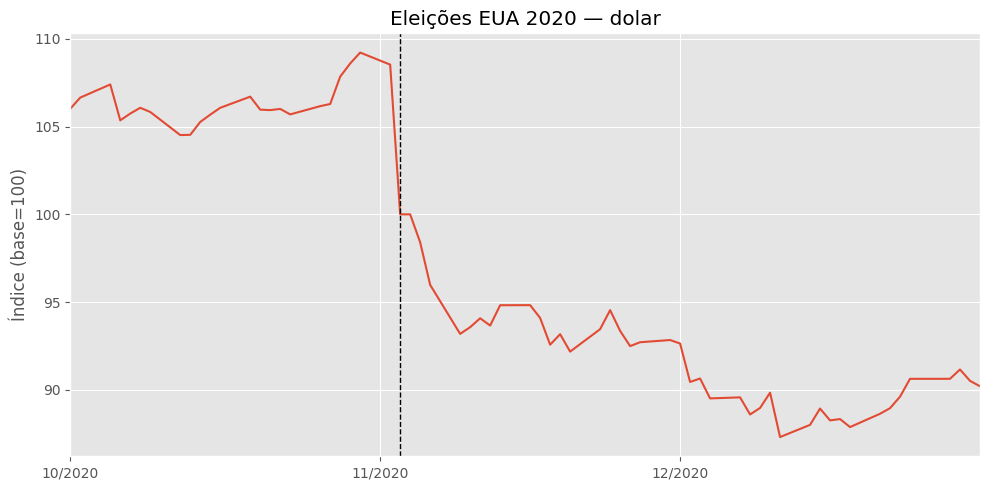

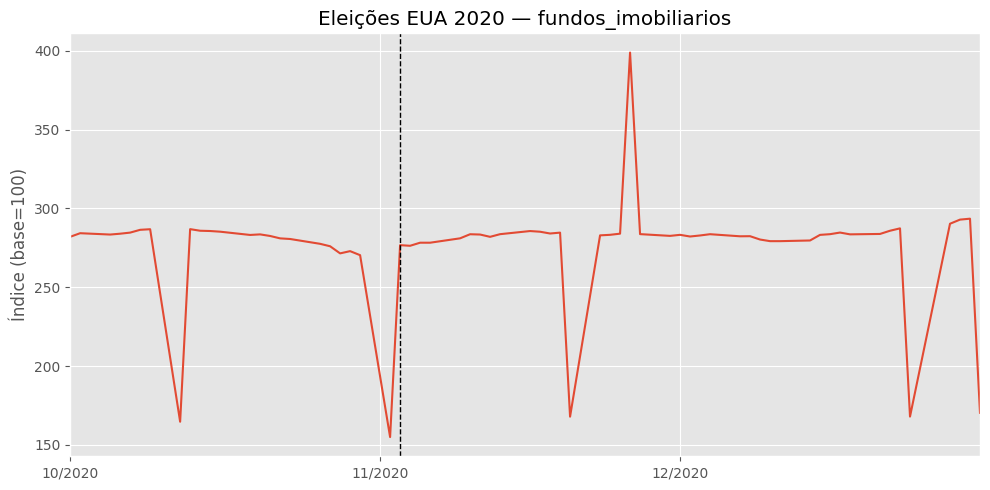

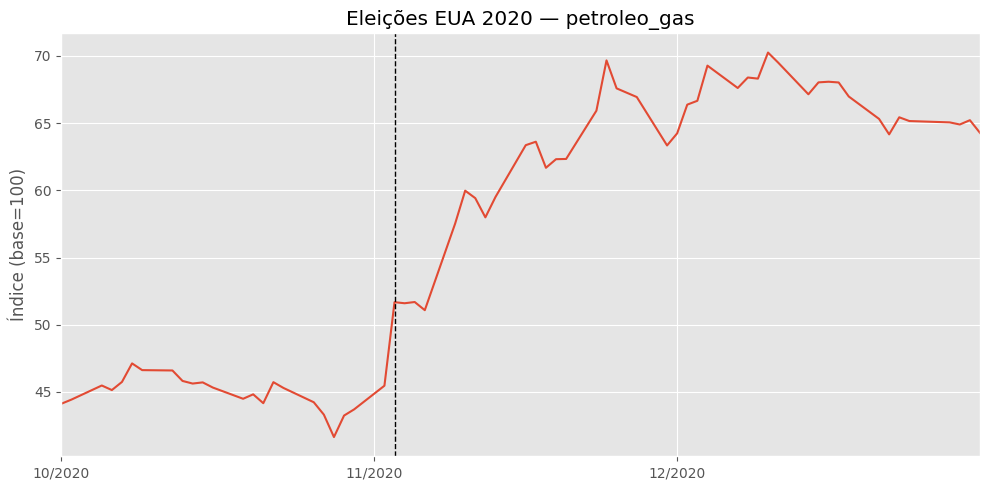

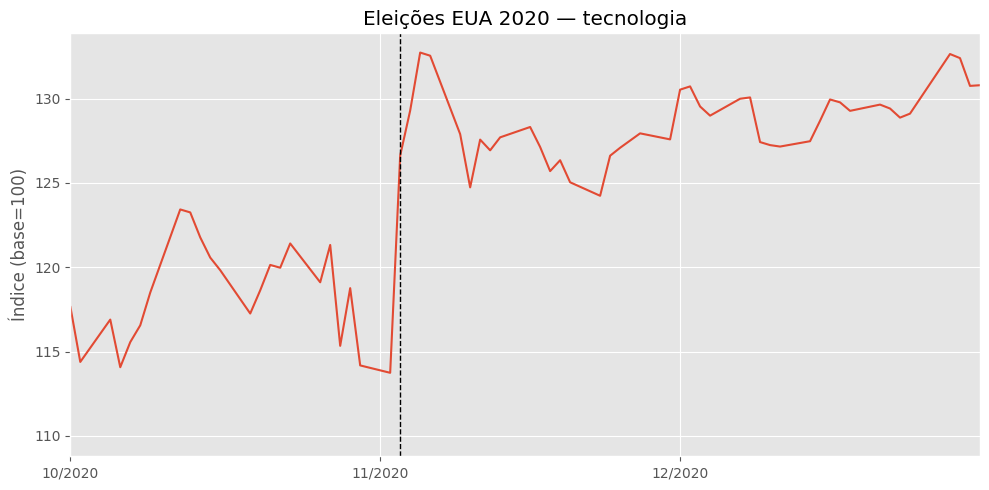

Evento: Eleições EUA 2024 (âncora: 2024-11-05)


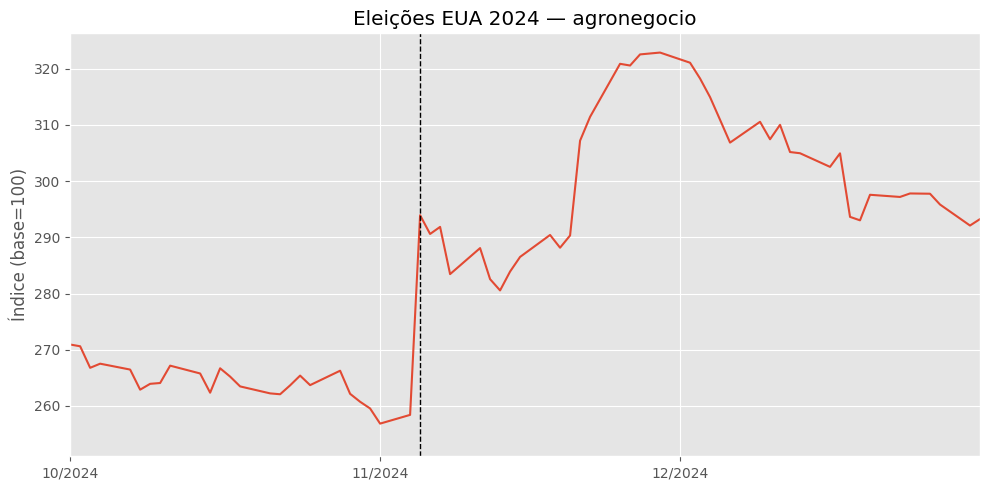

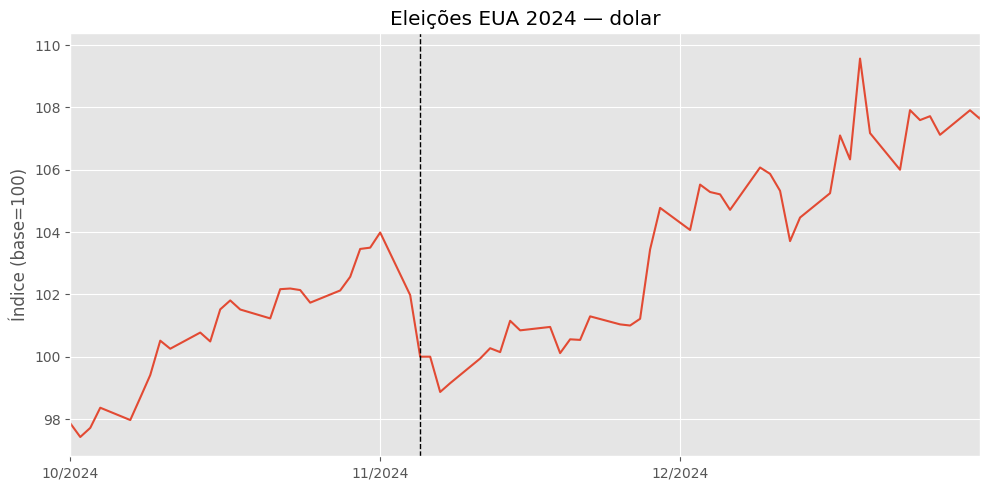

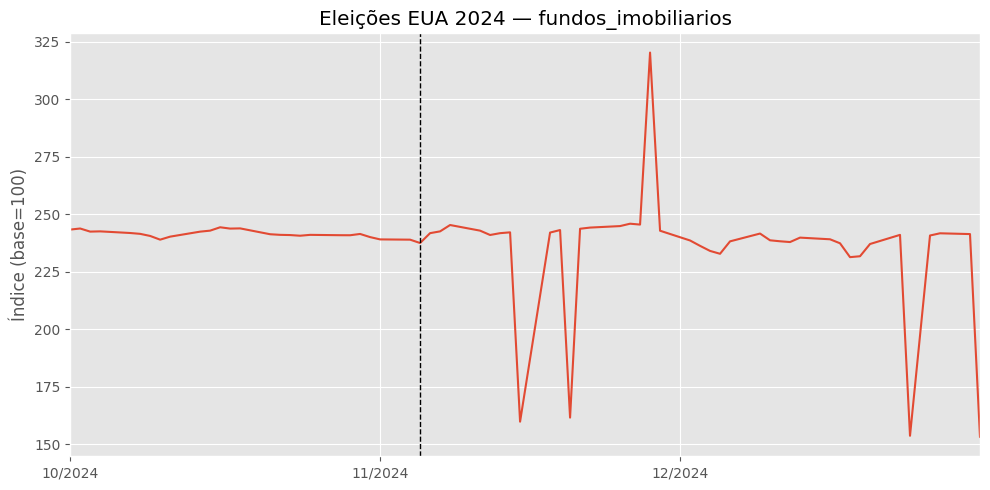

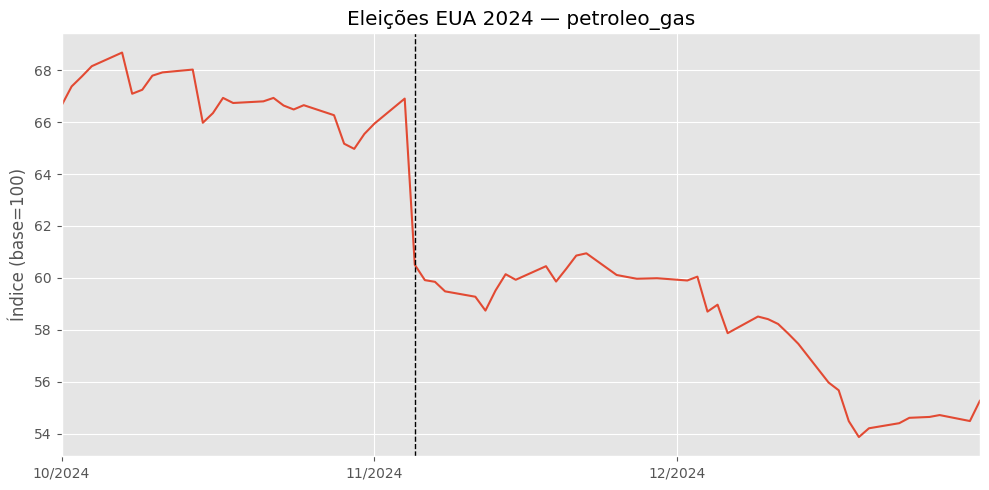

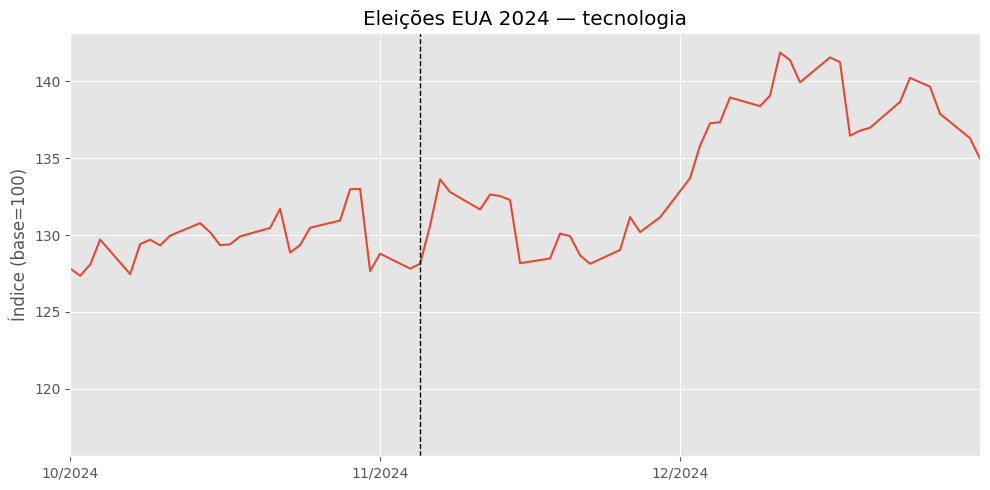

Evento: Invasão Rússia-Ucrânia (âncora: 2022-02-24)


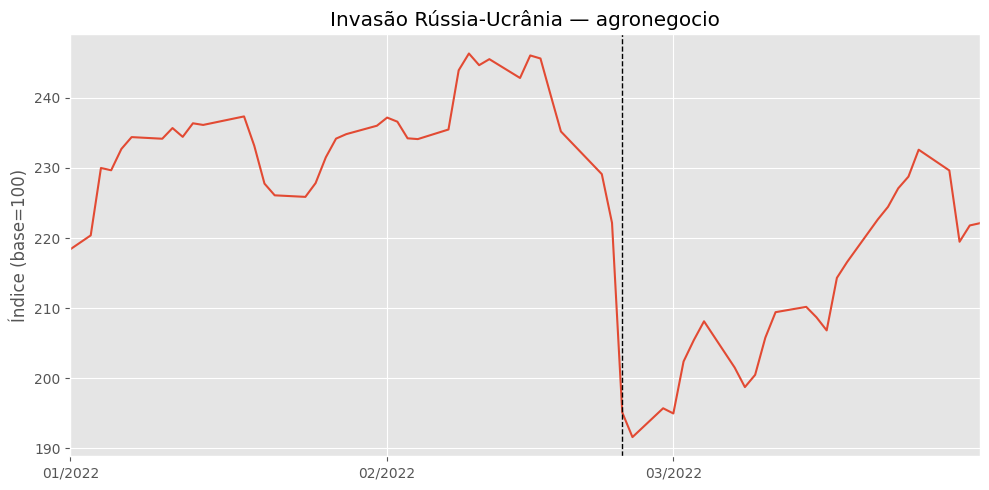

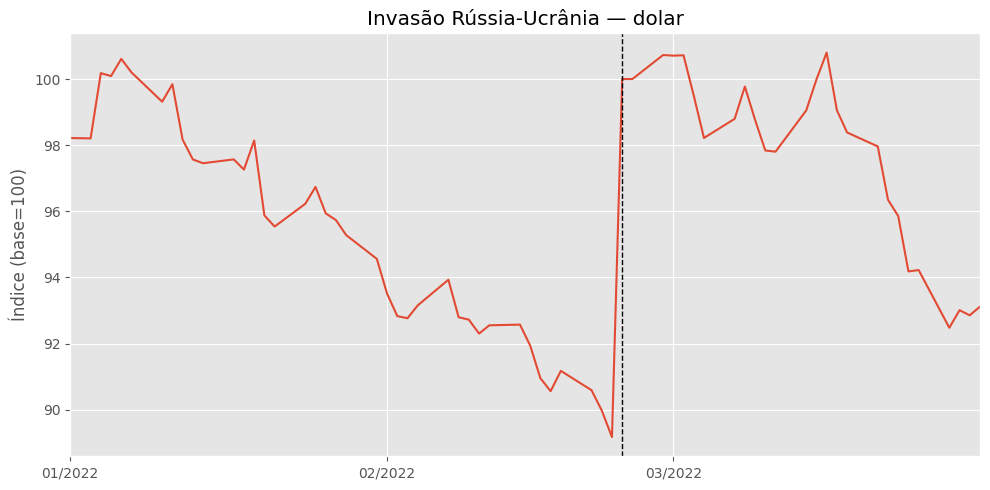

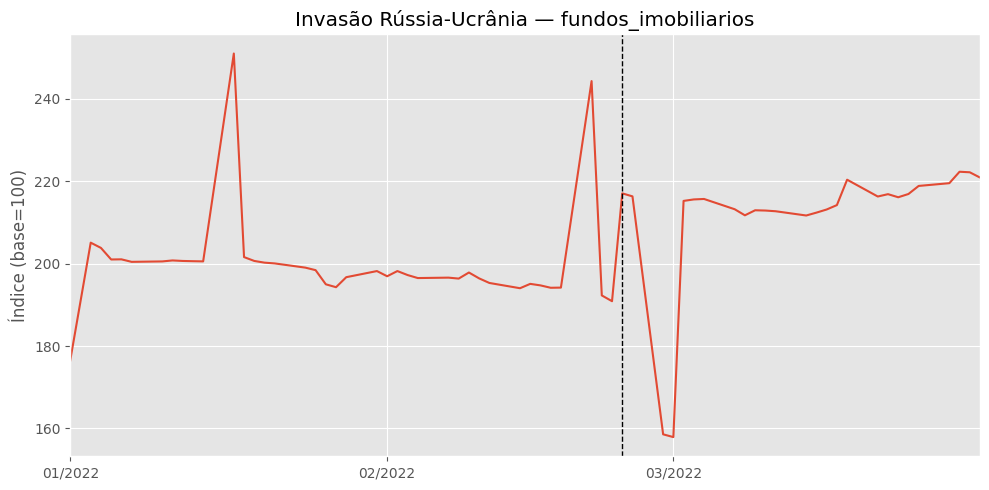

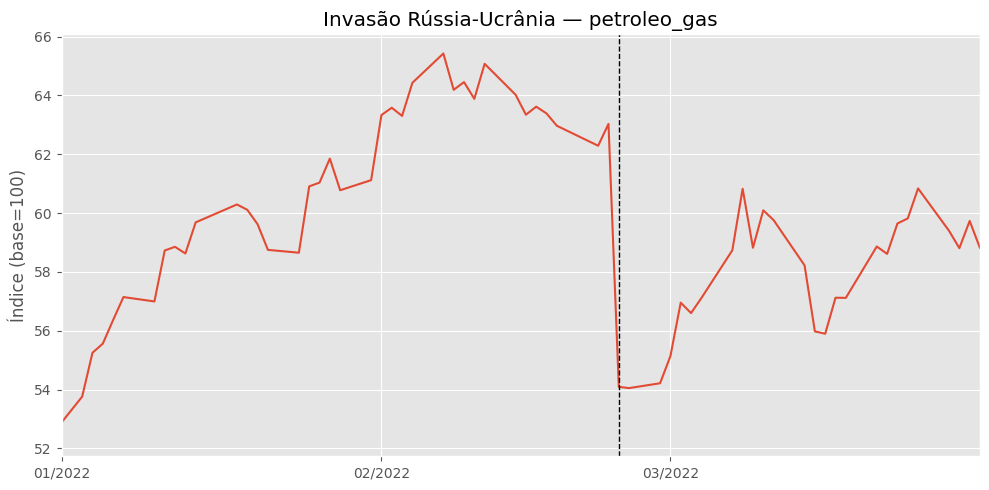

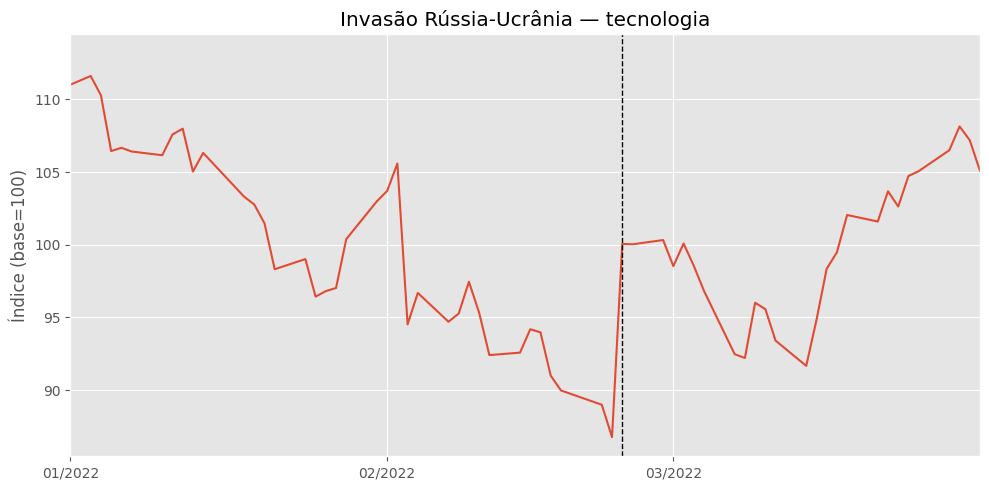

Evento: Pandemia COVID (WHO) (âncora: 2020-03-11)


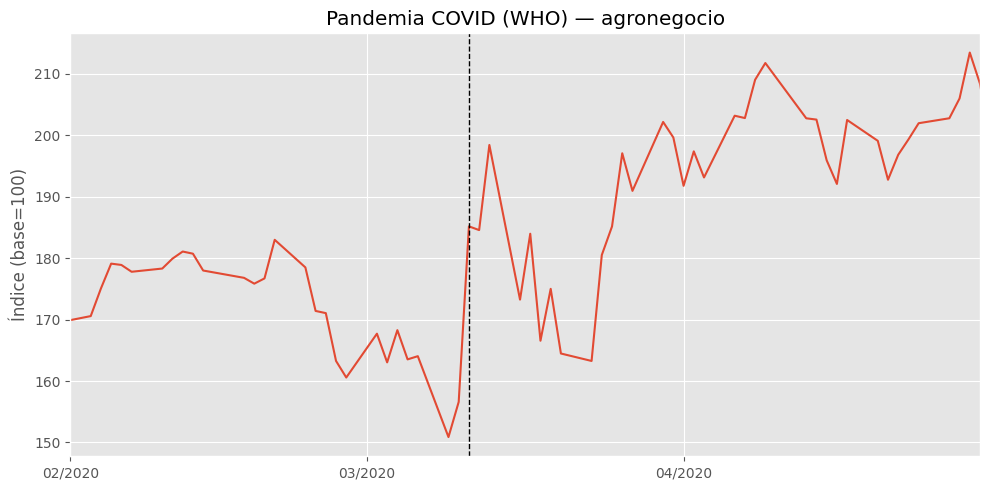

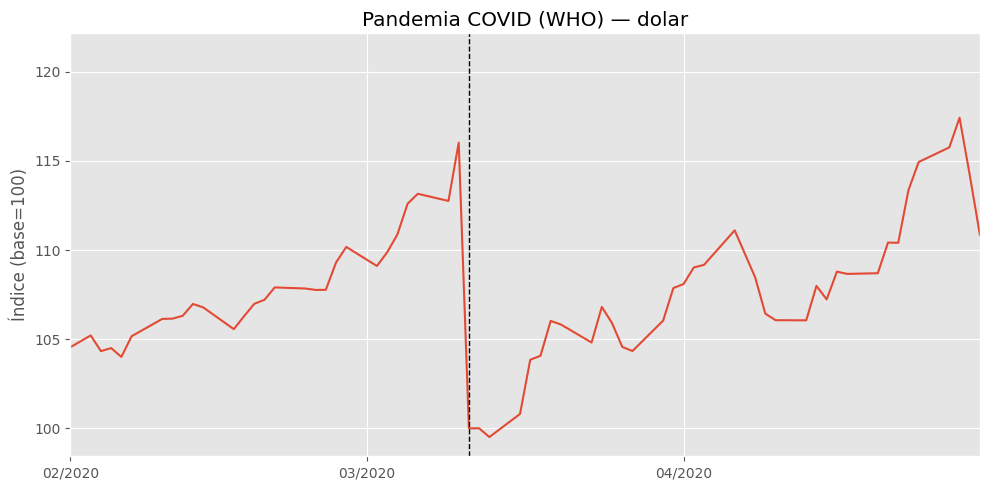

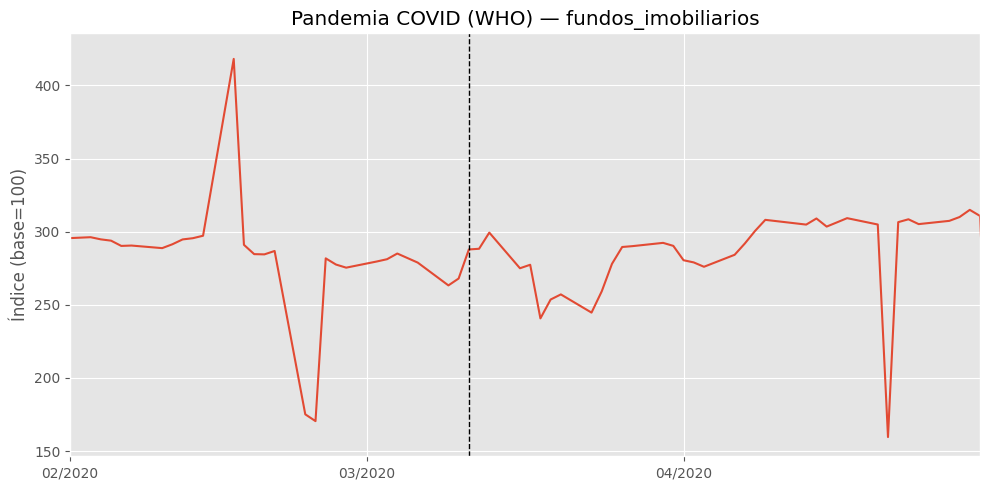

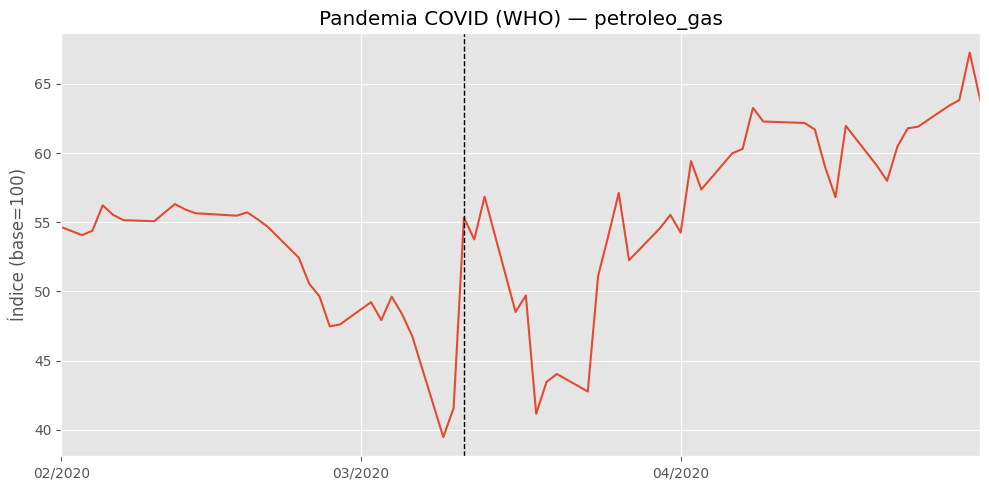

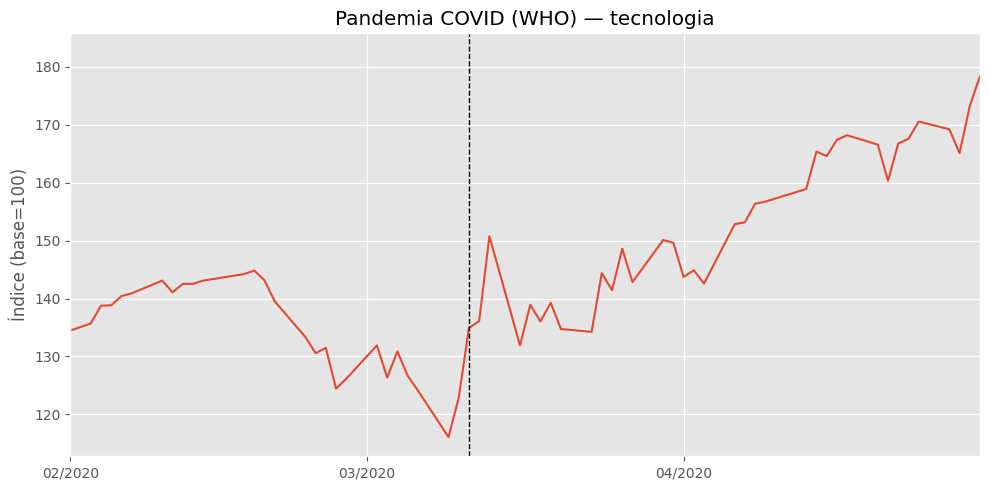

Evento: Guerra comercial EUA-China (Tarifas iniciais) (âncora: 2018-07-06)


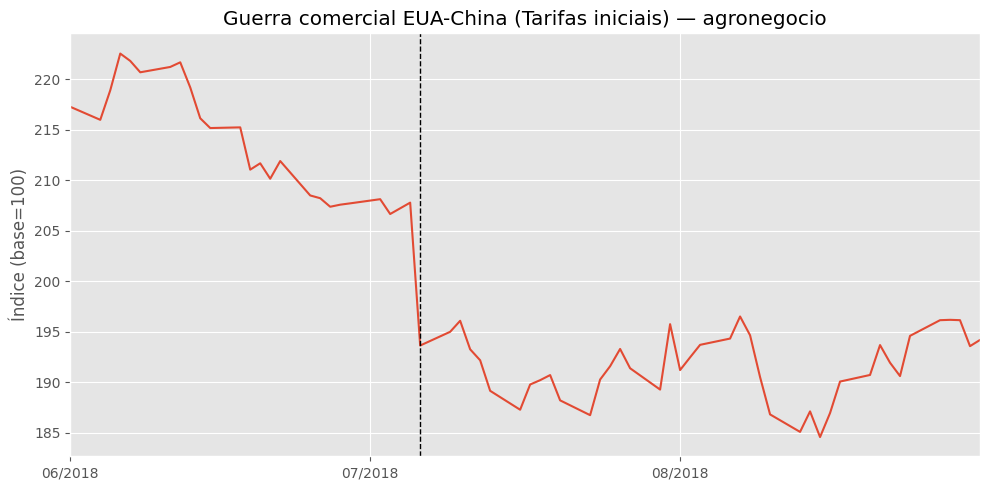

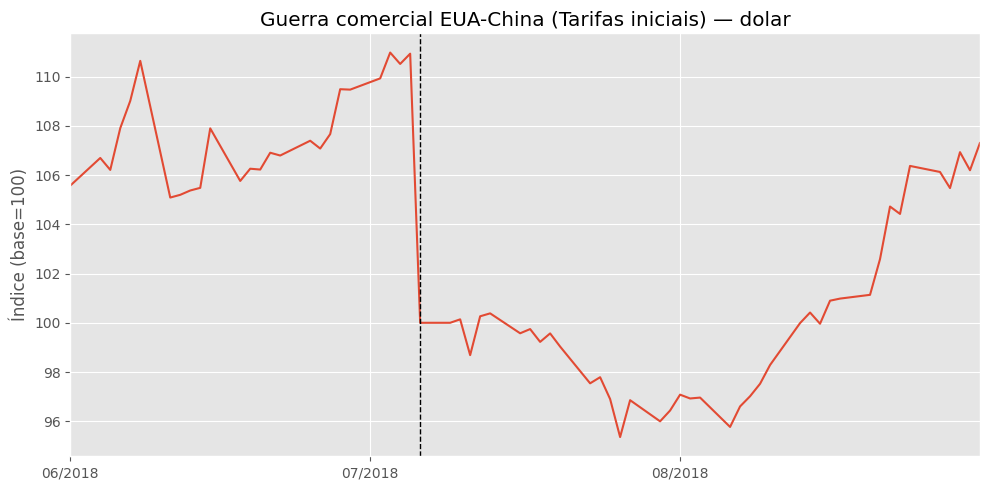

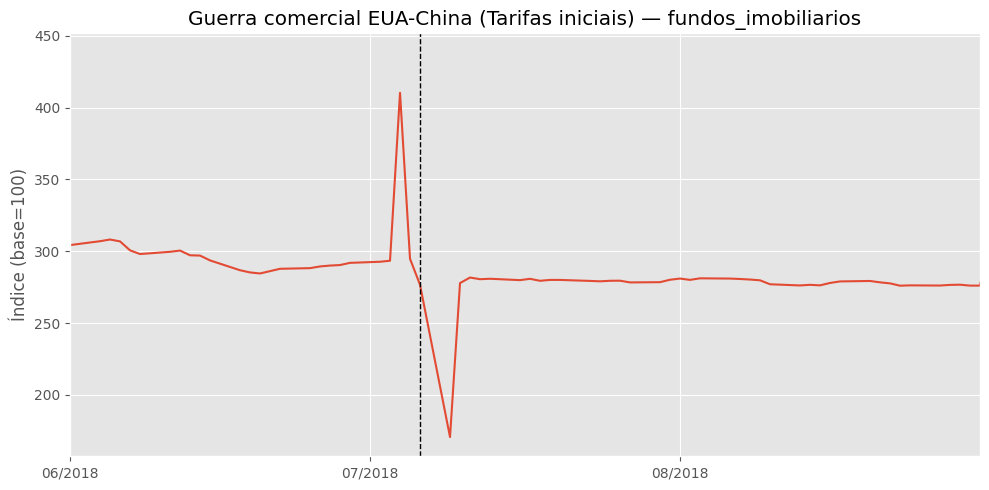

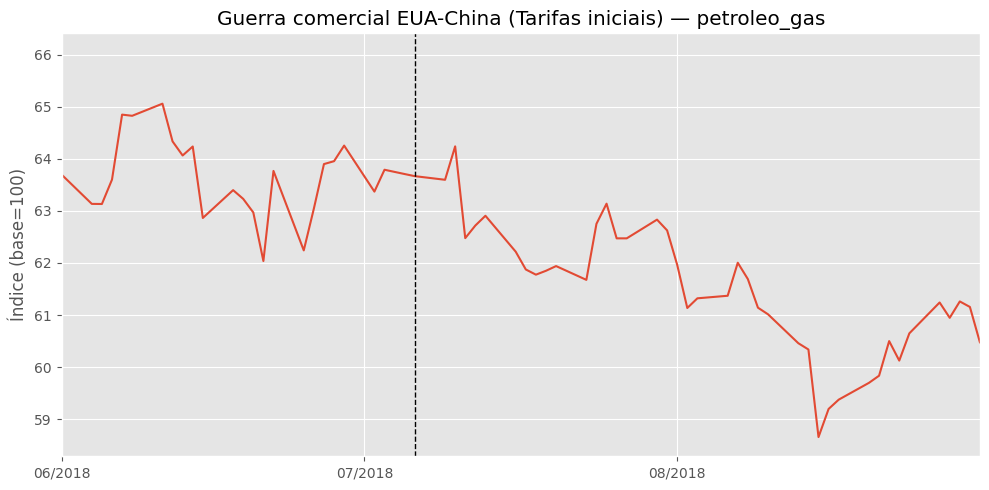

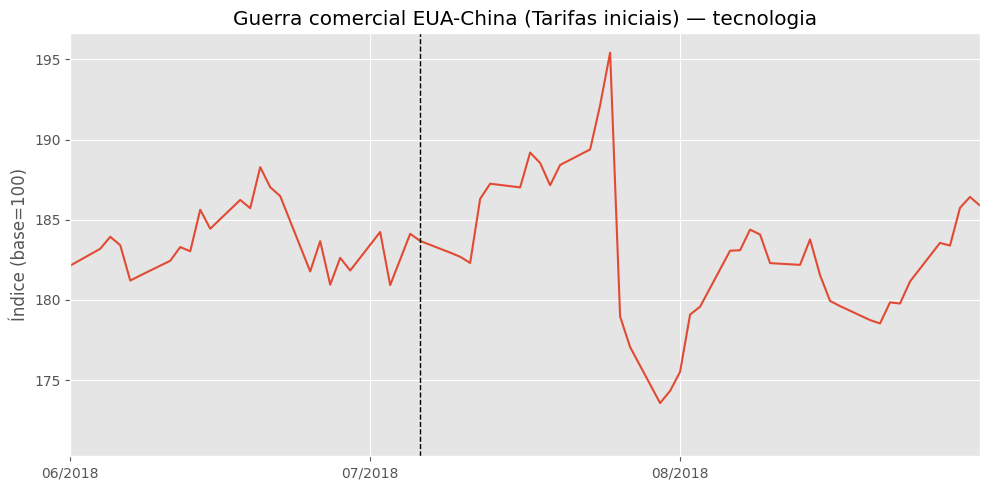

Evento: Guerra comercial EUA-China (Tarifas adicionais) (âncora: 2018-09-24)


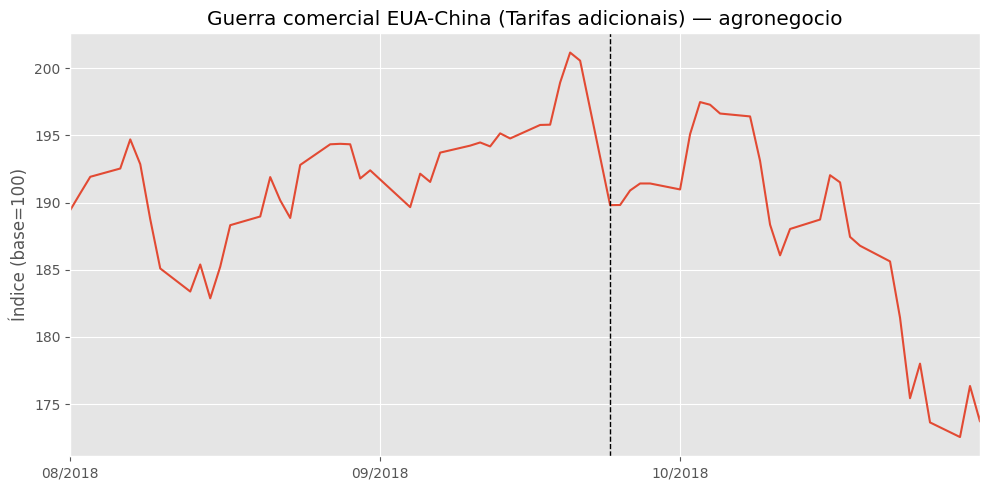

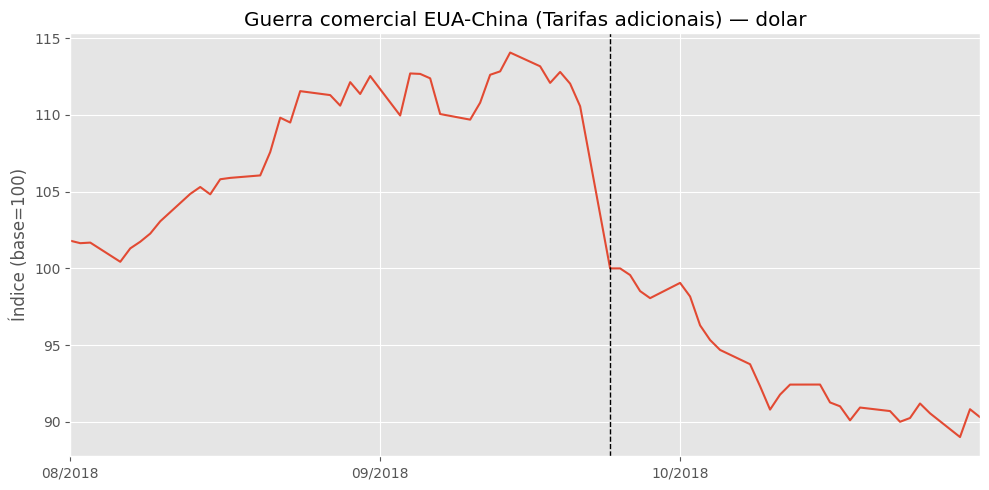

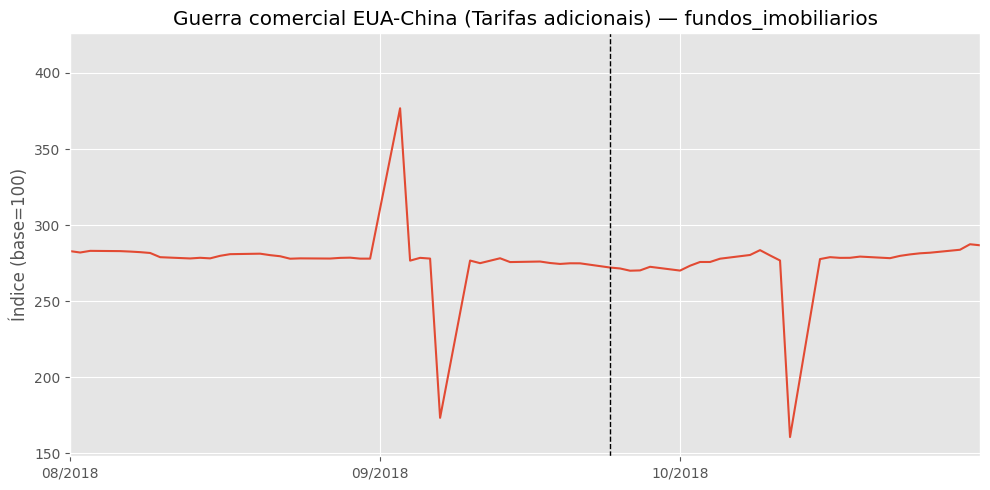

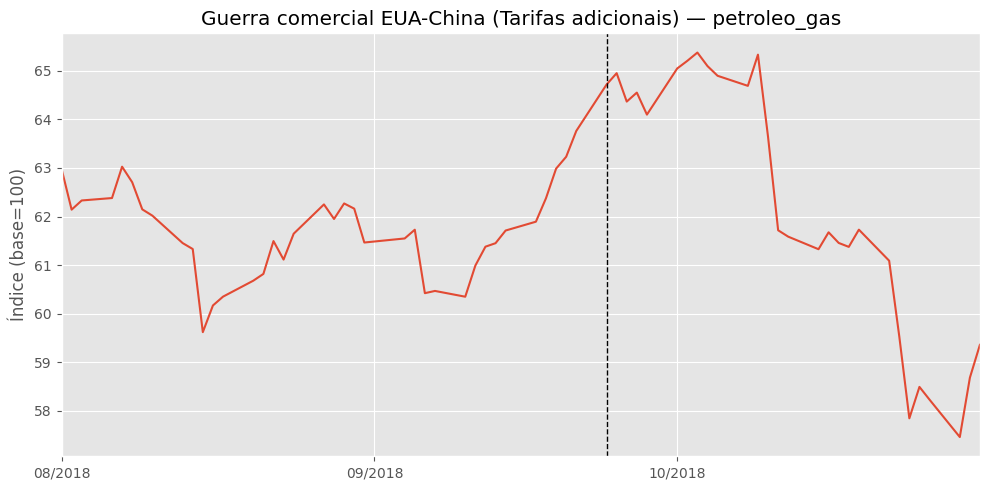

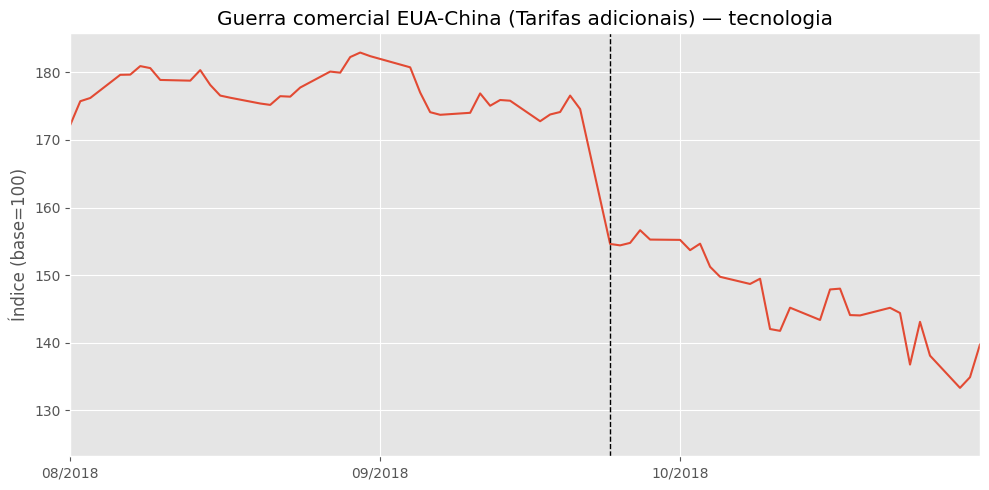

In [2]:
for ev in events:
    name = ev['name']
    anchor = ev['anchor_date']
    slug = slugify(name)
    print(f'Evento: {name} (âncora: {anchor})')

    base = 'hdfs://namenode:8020/datasets/yahoo_finance/curated/event_windows'

    win_paths = {
        'pre': f"{base}/{slug}/pre",
        'during': f"{base}/{slug}/during",
        'post': f"{base}/{slug}/post"
    }

    dfs = {}
    for w, p in win_paths.items():
        sdf = spark.read.parquet(p)
        sdf = normalize_by_anchor_spark(sdf, anchor)
        dfs[w] = aggregate_for_plot(sdf).toPandas()

    import pandas as pd
    from matplotlib.dates import DateFormatter, MonthLocator
    from pandas.tseries.offsets import MonthBegin, MonthEnd

    # Une pre/during/post em uma série única por categoria
    df_union = pd.concat(list(dfs.values()), ignore_index=True)
    df_union = df_union.drop_duplicates(subset=['category','date'])
    categorias = sorted(df_union['category'].unique())

    # Um gráfico por categoria dentro de cada evento
    for cat in categorias:
        fig, ax = plt.subplots(figsize=(10,5))
        dcat = df_union[df_union['category'] == cat]
        ax.plot(dcat['date'], dcat['index'], color='C0')

        # Eixo X mensal e formato MM/AAAA
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

        # Janela de visualização: janeiro a junho se evento for mar-abr (±2 meses)
        event_start = datetime.strptime(anchor, '%Y-%m-%d')
        event_end = datetime.strptime(ev.get('end_date', anchor), '%Y-%m-%d')
        x_start = (pd.Timestamp(event_start) - MonthBegin(2)).replace(day=1)
        x_end = (pd.Timestamp(event_end) + MonthEnd(2))
        ax.set_xlim(x_start.to_pydatetime(), x_end.to_pydatetime())

        # Linha de âncora sem aparecer na legenda
        ax.axvline(event_start, color='black', linestyle='--', linewidth=1, label='_nolegend_')

        ax.set_title(f"{name} — {cat}")
        ax.set_ylabel('Índice (base=100)')
        plt.tight_layout()
        plt.show()

spark.stop()
